In [113]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
from IPython.display import Image
import tensorflow.keras.backend as K
import splitfolders
import pandas as pd
import numpy as np
import seaborn as sns

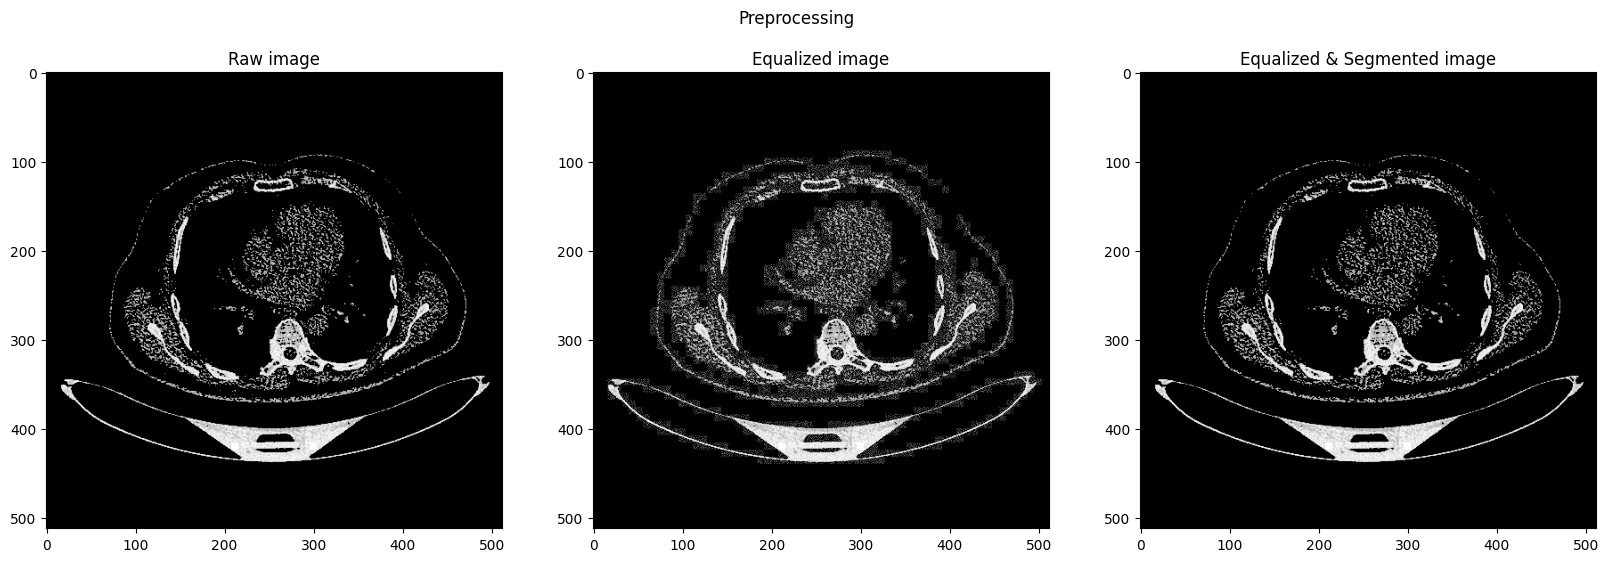

In [114]:
img = cv2.imread(r"F:\1\The IQ-OTHNCCD lung cancer dataset\Bengin cases\Bengin case (1).jpg", 0)
equalizedImage = cv2.equalizeHist(img)
e, segmentedImage = cv2.threshold(equalizedImage, 128, 255, cv2.THRESH_TOZERO)

plt.figure(figsize=(20, 6))

ax1 = plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Raw image')

ax2 = plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(equalizedImage, cv2.COLOR_BGR2RGB))
ax2.set_title('Equalized image')

ax3 = plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(segmentedImage, cv2.COLOR_BGR2RGB))
ax3.set_title('Equalized & Segmented image')

plt.suptitle('Preprocessing')

plt.show()

In [115]:
print(os.getcwd(), os.listdir())
DIR = r'F:\1\The IQ-OTHNCCD lung cancer dataset'
CATS = ['Bengin cases', 'Malignant cases', 'Normal cases']

DEST_DIR = r'F:\1\data'

f:\1\lung-cancer-detection-main ['CNN.png', 'eval.txt', 'InceptionV3.png', 'methodology.jpeg', 'MOBILENET.png', 'notebook.ipynb', 'README.md', 'ResNet50.png', 'VGG16.png', 'VGG19.png', 'Xception.png']


In [39]:
for category in CATS:
    path = os.path.join(DIR, category)
    for image in os.listdir(path):
        curr = os.path.join(path, image)
        img = cv2.imread(curr, 0)
        equalizedImage = cv2.equalizeHist(img)
        e, segmentedImage = cv2.threshold(equalizedImage, 128, 255, cv2.THRESH_TOZERO)
        if category in ['Normal cases', 'Bengin cases']:
            imgDest = curr.replace(DIR + '\\' + category, os.path.join(DEST_DIR, 'non-cancerous'))
            cv2.imwrite(imgDest, segmentedImage)
        else:
            imgDest = curr.replace(DIR + '\\' + category, os.path.join(DEST_DIR, 'cancerous'))
            cv2.imwrite(imgDest, segmentedImage)
    # Tạo thư mục đích nếu chưa có
        os.makedirs(os.path.dirname(imgDest), exist_ok=True)
        cv2.imwrite(imgDest, segmentedImage)
print("Processed data directory created successfully at", DEST_DIR)

Processed data directory created successfully at F:\1\data


<div style='font-size:100%;'>
    <a id='comparison'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Comparison between processed and unprocessed image</center>
    </h1>
</div>

In [40]:
image_path = os.path.join(DEST_DIR, 'non-cancerous', 'Bengin case (15).jpg')
print(f"Đang mở tệp: {image_path}")
image = cv2.imread(image_path)
if image is None:
    print("Không thể đọc tệp hình ảnh. Vui lòng kiểm tra đường dẫn và tên tệp.")

Đang mở tệp: F:\1\data\non-cancerous\Bengin case (15).jpg


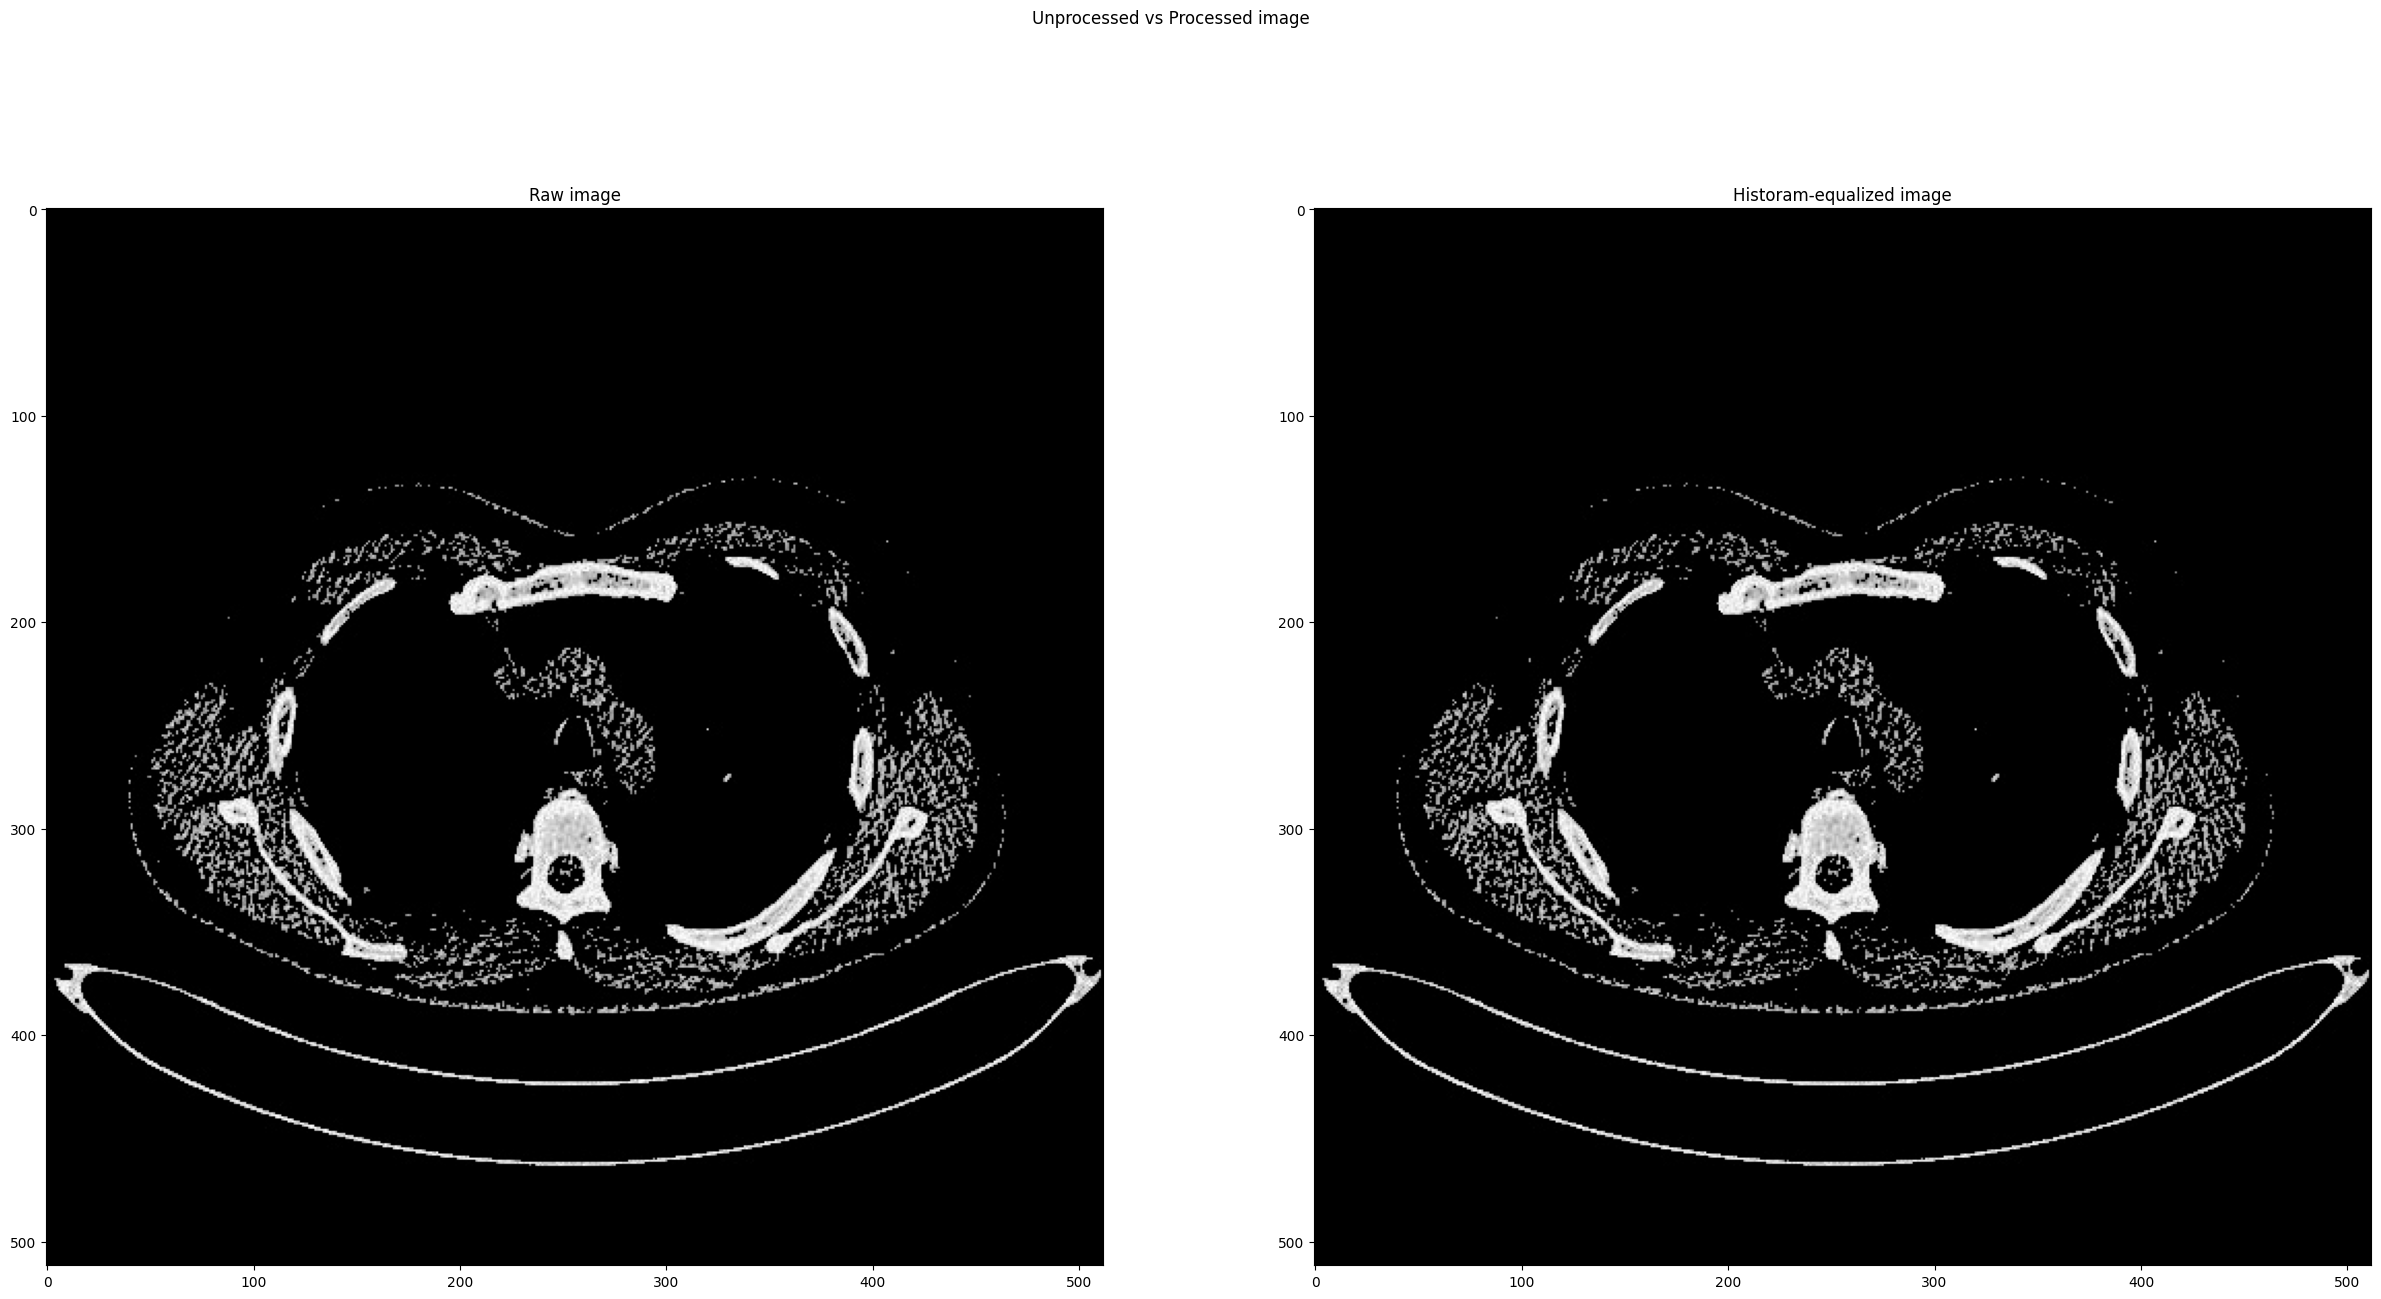

In [41]:
plt.figure(figsize=(30, 15))
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(os.path.join(DIR, CATS[0], 'Bengin case (15).jpg')))
plt.title('Raw image')
plt.subplot(1, 2, 2)
plt.imshow(cv2.imread(os.path.join(DEST_DIR,'non-cancerous', 'Bengin case (15).jpg')))
plt.title('Historam-equalized image')
plt.suptitle('Unprocessed vs Processed image')
plt.show()

<div style='font-size:100%;'>
    <a id='split'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Splitting the processed images</center>
    </h1>
</div>

In [42]:
FINAL_DIR = r'F:\1\processedData'

splitfolders.ratio(DEST_DIR, output=FINAL_DIR, seed=69420, ratio=(.7, 0.1,0.2))

Copying files: 1097 files [00:00, 2989.67 files/s]


In [43]:
BATCH_SIZE=32


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.2,
                                                                rotation_range=5,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                shear_range=0.2,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                fill_mode='nearest'
                                                                )

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

test_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [44]:
train_dataset  = train_datagen.flow_from_directory(directory = r'F:\1\processedData\train',
                                                   target_size = (224,224),
                                                   class_mode = 'binary',
                                                   batch_size = 32)

Found 767 images belonging to 2 classes.


In [45]:
valid_dataset = valid_datagen.flow_from_directory(directory = r'F:\1\processedData\val',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 32)

Found 109 images belonging to 2 classes.


In [46]:
test_dataset = test_datagen.flow_from_directory(directory = r'F:\1\processedData\test',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 32)

Found 221 images belonging to 2 classes.


<div style='font-size:100%;'>
    <a id='nn'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Neural nets</center>
    </h1>
</div>

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='Accuracy'),
      tf.keras.metrics.Precision(name='Precision'),
      tf.keras.metrics.Recall(name='Recall'),
      tf.keras.metrics.AUC(name='AUC'),
]

def plot_history(hist, name):
    # Vẽ và lưu biểu đồ Accuracy
    plt.figure()
    plt.plot(hist.history['Accuracy'])
    plt.plot(hist.history['val_Accuracy'])
    plt.title(f'{name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Vẽ và lưu biểu đồ Loss
    plt.figure()
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title(f'{name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Vẽ và lưu biểu đồ Precision
    plt.figure()
    plt.plot(hist.history['Precision'])
    plt.plot(hist.history['val_Precision'])
    plt.title(f'{name} Precision')
    plt.ylabel('Precision')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

<h1 align="center" ><a id='vgg16'><b>VGG16<b></a></h1>

In [50]:
VGG16_base = tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=False,weights="imagenet")

for layer in VGG16_base.layers:
    layer.trainable = False

VGG16=tf.keras.Sequential()
VGG16.add(VGG16_base)
VGG16.add(tf.keras.layers.Dropout(0.5))
VGG16.add(tf.keras.layers.Flatten())
VGG16.add(tf.keras.layers.BatchNormalization())
VGG16.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
VGG16.add(tf.keras.layers.BatchNormalization())
VGG16.add(tf.keras.layers.Activation('relu'))
VGG16.add(tf.keras.layers.Dropout(0.5))
VGG16.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
VGG16.add(tf.keras.layers.BatchNormalization())
VGG16.add(tf.keras.layers.Activation('relu'))
VGG16.add(tf.keras.layers.Dropout(0.5))
VGG16.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
VGG16.add(tf.keras.layers.BatchNormalization())
VGG16.add(tf.keras.layers.Activation('relu'))
VGG16.add(tf.keras.layers.Dense(1,activation='sigmoid'))

VGG16.summary()

VGG16.compile(optimizer='rmsprop',
              loss=tf.keras.losses.binary_crossentropy, metrics=METRICS)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 25088)          │       100,352 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       802,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,620,417 (59.59 MB)

 Trainable params: 855,361 (3.26 MB)

 Non-trainable params: 14,765,056 (56.32 MB)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


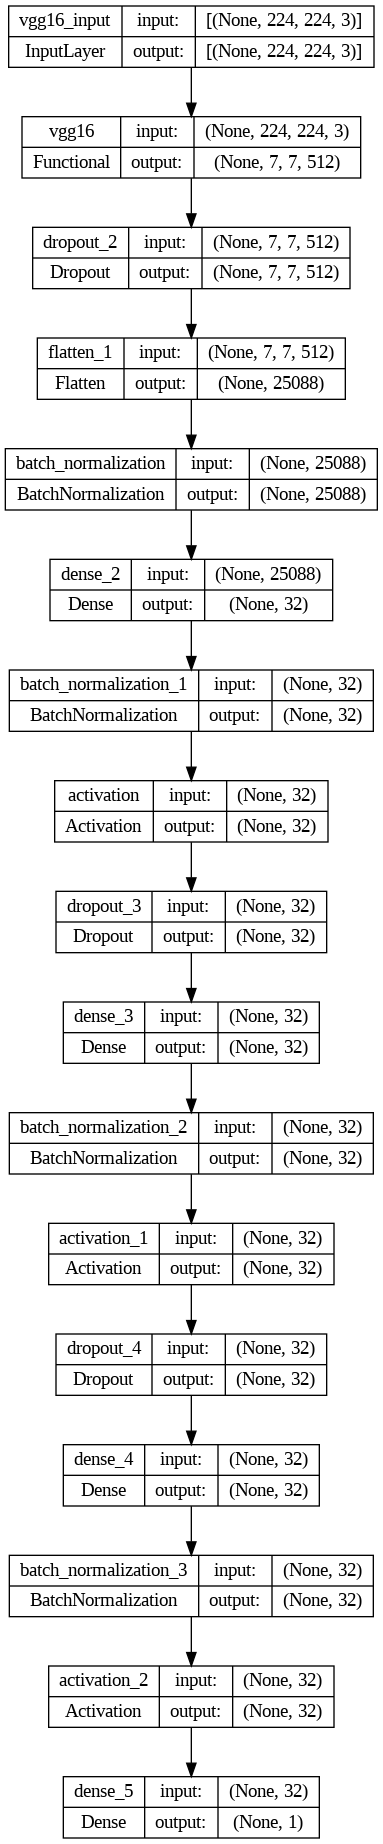

In [51]:
tf.keras.utils.plot_model(VGG16, to_file='VGG16.png', show_shapes=True,show_layer_names=True)
Image(filename='VGG16.png')

In [52]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint('VGG16.h5.keras', save_best_only=True, mode='auto', monitor='val_accuracy')

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

VGG16_history = VGG16.fit(train_dataset,validation_data=valid_dataset, epochs = 36, callbacks=[lrd,mcp,es], shuffle=True)

C:\Users\yumin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/36
24/24 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - AUC: 0.6436 - Accuracy: 0.5636 - Precision: 0.5407 - Recall: 0.7444 - loss: 0.6975 - val_AUC: 0.8957 - val_Accuracy: 0.5505 - val_Precision: 0.5196 - val_Recall: 1.0000 - val_loss: 0.9500 - learning_rate: 0.0010
Epoch 2/36


C:\Users\yumin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - AUC: 0.7609 - Accuracy: 0.7063 - Precision: 0.6872 - Recall: 0.7099 - loss: 0.5933 - val_AUC: 0.9732 - val_Accuracy: 0.6697 - val_Precision: 0.5955 - val_Recall: 1.0000 - val_loss: 0.5438 - learning_rate: 0.0010
Epoch 3/36
24/24 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - AUC: 0.8487 - Accuracy: 0.8003 - Precision: 0.8154 - Recall: 0.7698 - loss: 0.5199 - val_AUC: 0.9774 - val_Accuracy: 0.8532 - val_Precision: 0.7681 - val_Recall: 1.0000 - val_loss: 0.4070 - learning_rate: 0.0010
Epoch 4/36
24/24 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - AUC: 0.8688 - Accuracy: 0.8009 - Precision: 0.8413 - Recall: 0.7325 - loss: 0.4845 - val_AUC: 0.9826 - val_Accuracy: 0.8624 - val_Precision: 0.7794 - val_Recall: 1.0000 - val_loss: 0.3630 - learning_rate: 0.0010
Epoch 5/36
24/24 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - AUC: 0.9058 - Accuracy: 0.8088 - Precision: 0.8514 - Recall: 0.7563 - loss: 0.4196 - val_AUC: 0.9901 - val_Accuracy: 0.9633 - val_Precision: 0.9455 - val_Recall: 0.981

In [53]:
VGG16_scores = VGG16.evaluate(test_dataset, verbose=1)

C:\Users\yumin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - AUC: 0.9858 - Accuracy: 0.9625 - Precision: 0.9631 - Recall: 0.9627 - loss: 0.1642


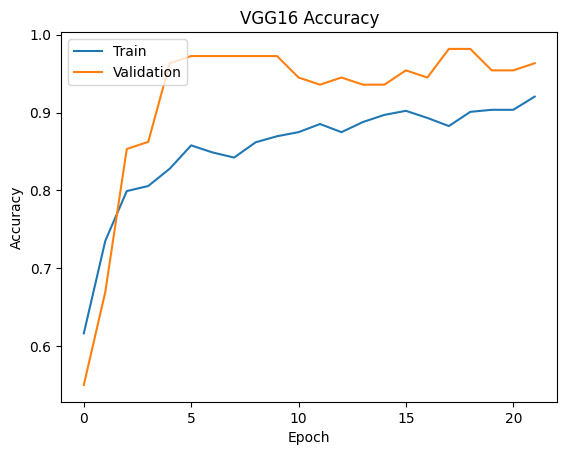

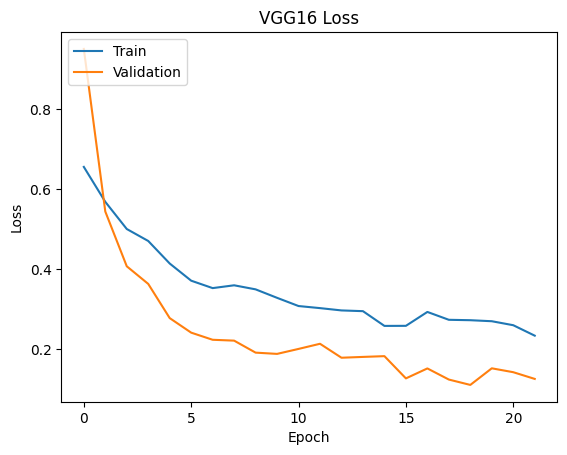

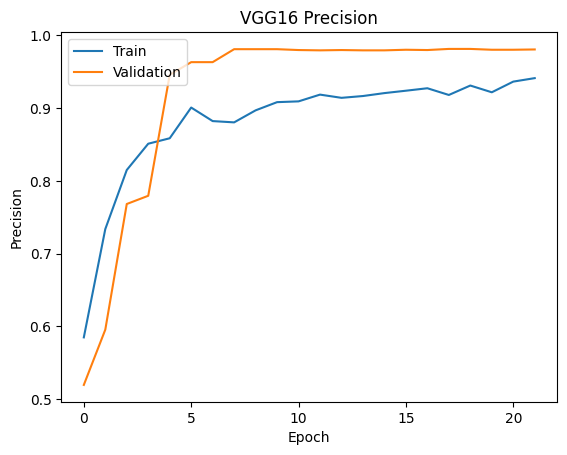

In [104]:
plot_history(VGG16_history, 'VGG16')

<h1 align="center" ><a id='mobilenet'><b>MobileNet<b></a></h1>

In [55]:
MOBILENET_base =  tf.keras.applications.MobileNet(input_shape=(224,224,3), include_top= False)

for layer in MOBILENET_base.layers:
    layer.trainable = False

MOBILENET=tf.keras.Sequential()
MOBILENET.add(MOBILENET_base)
MOBILENET.add(tf.keras.layers.Dropout(0.5))
MOBILENET.add(tf.keras.layers.Flatten())
MOBILENET.add(tf.keras.layers.BatchNormalization())
MOBILENET.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
MOBILENET.add(tf.keras.layers.BatchNormalization())
MOBILENET.add(tf.keras.layers.Activation('relu'))
MOBILENET.add(tf.keras.layers.Dropout(0.5))
MOBILENET.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
MOBILENET.add(tf.keras.layers.BatchNormalization())
MOBILENET.add(tf.keras.layers.Activation('relu'))
MOBILENET.add(tf.keras.layers.Dropout(0.5))
MOBILENET.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
MOBILENET.add(tf.keras.layers.BatchNormalization())
MOBILENET.add(tf.keras.layers.Activation('relu'))
MOBILENET.add(tf.keras.layers.Dense(1,activation='sigmoid'))

MOBILENET.summary()

MOBILENET.compile(optimizer='rmsprop',
              loss=tf.keras.losses.binary_crossentropy, metrics=METRICS)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 50176)          │       200,704 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │     1,605,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,037,761 (19.22 MB)

 Trainable params: 1,708,353 (6.52 MB)

 Non-trainable params: 3,329,408 (12.70 MB)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


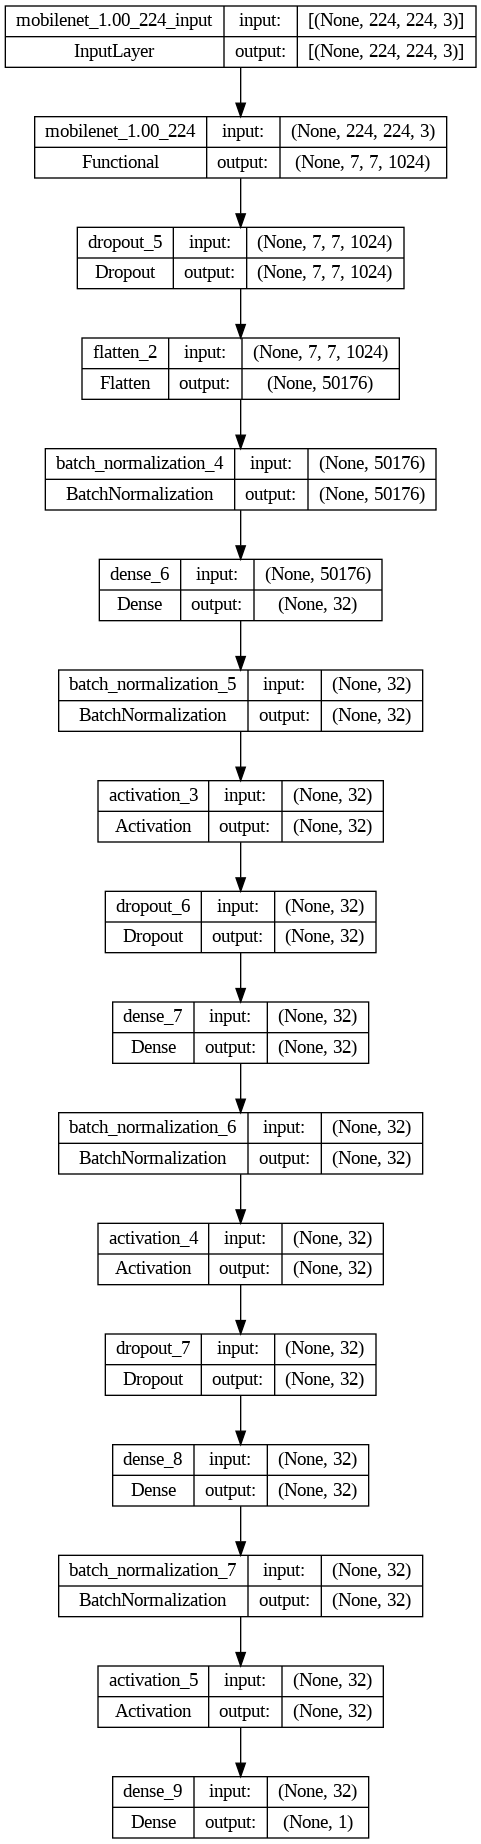

In [56]:
tf.keras.utils.plot_model(MOBILENET, to_file='MOBILENET.png', show_shapes=True,show_layer_names=True)
Image(filename='MOBILENET.png')

In [57]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint('MOBILENET.h5.keras', save_best_only=True, mode='auto', monitor='val_accuracy')

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

MOBILENET_history = MOBILENET.fit(train_dataset,validation_data=valid_dataset,epochs = 36,verbose = 1, callbacks=[lrd, mcp, es], shuffle=True)

Epoch 1/36
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 423ms/step - AUC: 0.8404 - Accuracy: 0.6929 - Precision: 0.6267 - Recall: 0.9489 - loss: 0.7338 - val_AUC: 0.9417 - val_Accuracy: 0.4954 - val_Precision: 0.4907 - val_Recall: 1.0000 - val_loss: 1.2868 - learning_rate: 0.0010
Epoch 2/36


C:\Users\yumin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 426ms/step - AUC: 0.8179 - Accuracy: 0.6487 - Precision: 0.5781 - Recall: 0.9058 - loss: 0.5897 - val_AUC: 0.9995 - val_Accuracy: 0.8165 - val_Precision: 0.7260 - val_Recall: 1.0000 - val_loss: 0.5143 - learning_rate: 0.0010
Epoch 3/36
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 409ms/step - AUC: 0.8798 - Accuracy: 0.7469 - Precision: 0.6745 - Recall: 0.8935 - loss: 0.5164 - val_AUC: 0.9983 - val_Accuracy: 0.8807 - val_Precision: 0.8030 - val_Recall: 1.0000 - val_loss: 0.3020 - learning_rate: 0.0010
Epoch 4/36
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 436ms/step - AUC: 0.9329 - Accuracy: 0.8376 - Precision: 0.7854 - Recall: 0.9000 - loss: 0.4291 - val_AUC: 0.9985 - val_Accuracy: 0.9083 - val_Precision: 0.8413 - val_Recall: 1.0000 - val_loss: 0.2282 - learning_rate: 0.0010
Epoch 5/36
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 506ms/step - AUC: 0.9501 - Accuracy: 0.8804 - Precision: 0.8668 - Recall: 0.8787 - loss: 0.3642 - val_AUC: 0.9990 - val_Accuracy: 0.9633 - val_Precision: 0.9298 - val_R

In [58]:
MOBILENET_scores = MOBILENET.evaluate(test_dataset, verbose=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - AUC: 0.9943 - Accuracy: 0.9714 - Precision: 0.9569 - Recall: 0.9897 - loss: 0.0874


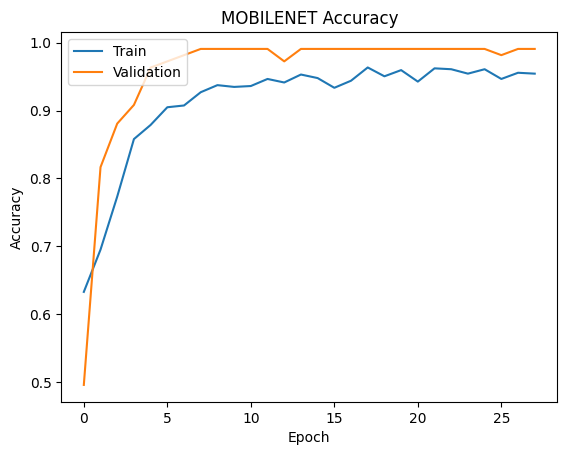

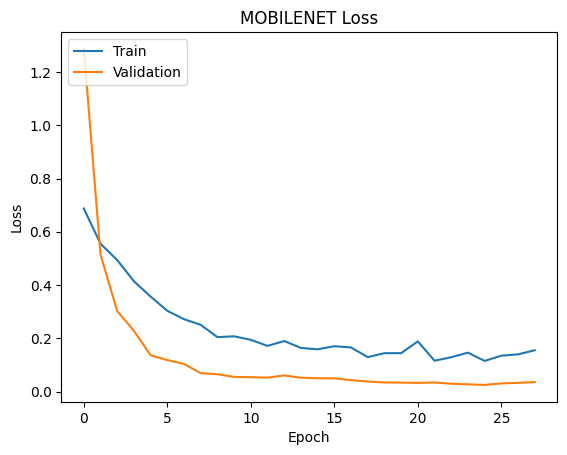

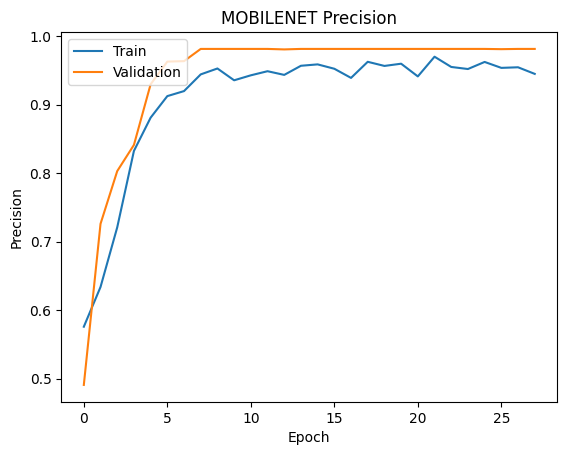

In [105]:
plot_history(MOBILENET_history, 'MOBILENET')

<h1 align="center" ><a id='inceptionv3'><b>InceptionV3<b></a></h1>

In [60]:
InceptionV3_base = tf.keras.applications.InceptionV3(input_shape=(224,224,3),include_top=False,weights="imagenet")

for layer in InceptionV3_base.layers:
    layer.trainable = False

InceptionV3=tf.keras.Sequential()
InceptionV3.add(InceptionV3_base)
InceptionV3.add(tf.keras.layers.Dropout(0.5))
InceptionV3.add(tf.keras.layers.Flatten())
InceptionV3.add(tf.keras.layers.BatchNormalization())
InceptionV3.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
InceptionV3.add(tf.keras.layers.BatchNormalization())
InceptionV3.add(tf.keras.layers.Activation('relu'))
InceptionV3.add(tf.keras.layers.Dropout(0.5))
InceptionV3.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
InceptionV3.add(tf.keras.layers.BatchNormalization())
InceptionV3.add(tf.keras.layers.Activation('relu'))
InceptionV3.add(tf.keras.layers.Dropout(0.5))
InceptionV3.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
InceptionV3.add(tf.keras.layers.BatchNormalization())
InceptionV3.add(tf.keras.layers.Activation('relu'))
InceptionV3.add(tf.keras.layers.Dense(1,activation='sigmoid'))

InceptionV3.summary()

InceptionV3.compile(optimizer='rmsprop',
              loss=tf.keras.losses.binary_crossentropy, metrics=METRICS)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 5, 5, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_102         │ (None, 51200)          │       204,800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │     1,638,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_103         │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_100 (Activation)     │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_104         │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_101 (Activation)     │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_105         │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_102 (Activation)     │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,648,545 (90.21 MB)

 Trainable params: 1,743,169 (6.65 MB)

 Non-trainable params: 21,905,376 (83.56 MB)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


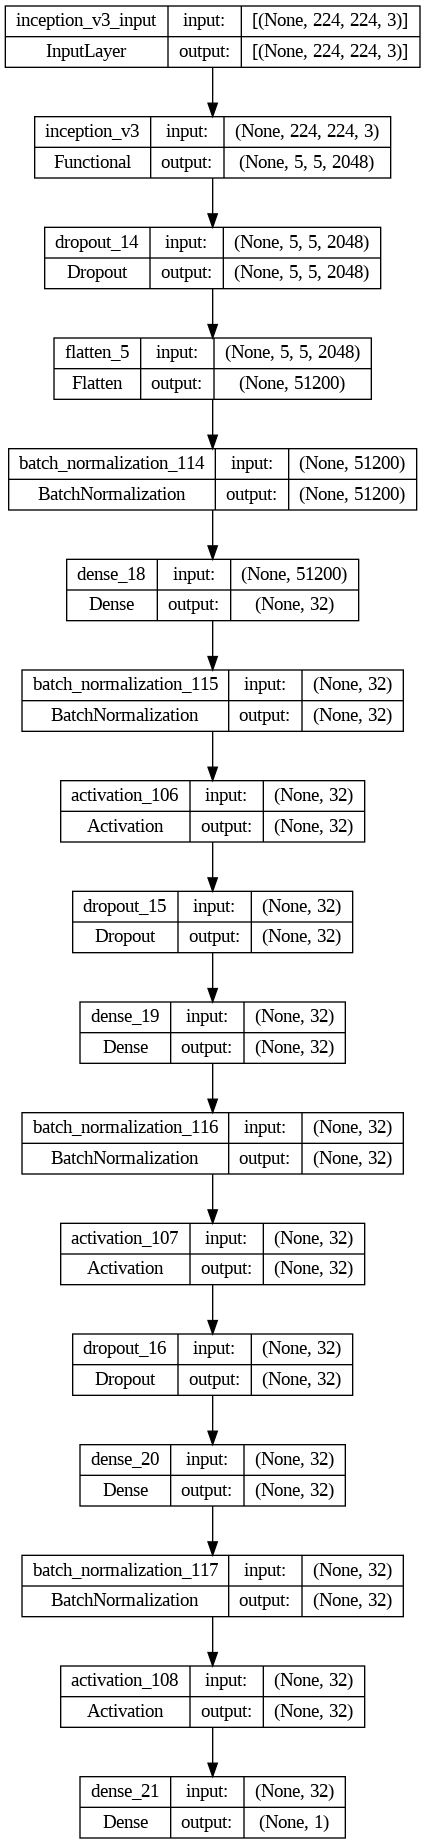

In [61]:
tf.keras.utils.plot_model(InceptionV3, to_file='./InceptionV3.png', show_shapes=True,show_layer_names=True)
Image(filename='InceptionV3.png')

In [62]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint('InceptionV3.h5.keras', save_best_only=True, mode='auto', monitor='val_accuracy')

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

InceptionV3_history = InceptionV3.fit(train_dataset,validation_data=valid_dataset,epochs = 36,verbose = 1, callbacks=[lrd, mcp, es], shuffle=True)

Epoch 1/36
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 753ms/step - AUC: 0.8701 - Accuracy: 0.7819 - Precision: 0.7726 - Recall: 0.7820 - loss: 0.6427 - val_AUC: 0.5536 - val_Accuracy: 0.4862 - val_Precision: 0.4862 - val_Recall: 1.0000 - val_loss: 5.2298 - learning_rate: 0.0010
Epoch 2/36
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 714ms/step - AUC: 0.8174 - Accuracy: 0.7644 - Precision: 0.7867 - Recall: 0.7139 - loss: 0.5353 - val_AUC: 0.8723 - val_Accuracy: 0.5138 - val_Precision: 0.5000 - val_Recall: 1.0000 - val_loss: 2.0089 - learning_rate: 0.0010
Epoch 3/36
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 700ms/step - AUC: 0.8855 - Accuracy: 0.8024 - Precision: 0.8215 - Recall: 0.7592 - loss: 0.4647 - val_AUC: 0.9594 - val_Accuracy: 0.7431 - val_Precision: 0.6543 - val_Recall: 1.0000 - val_loss: 0.8168 - learning_rate: 0.0010
Epoch 4/36
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 683ms/step - AUC: 0.8810 - Accuracy: 0.8070 - Precision: 0.8303 - Recall: 0.7465 - loss: 0.4450 - val_AUC: 0.9695 - val_Accuracy: 0.7798 - val_Precision: 0.6

In [63]:
InceptionV3_scores = InceptionV3.evaluate(test_dataset, verbose=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 544ms/step - AUC: 0.9855 - Accuracy: 0.9596 - Precision: 0.9547 - Recall: 0.9635 - loss: 0.1403


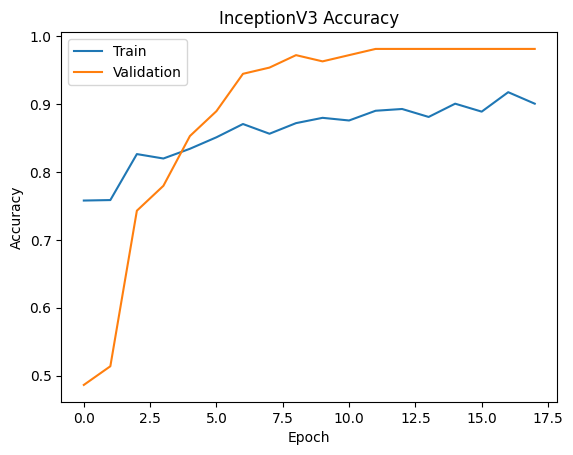

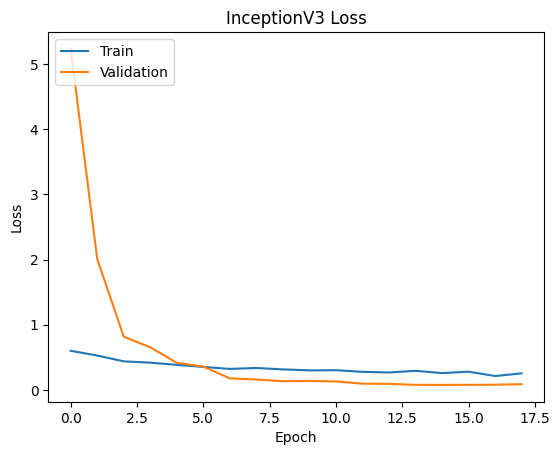

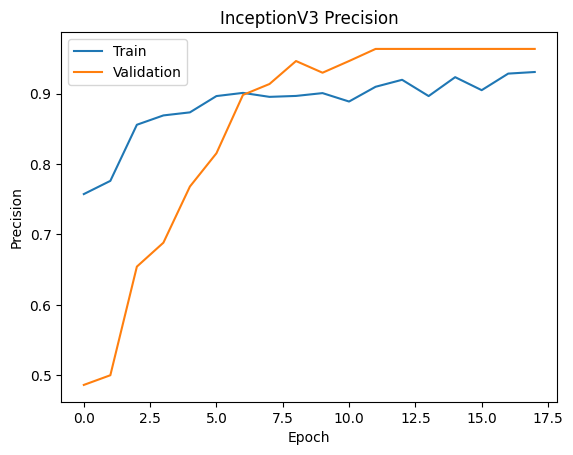

In [106]:
plot_history(InceptionV3_history, 'InceptionV3')

<div style='font-size:100%;'>
    <a id='example'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center> Example: Prediction vs Truth </center>
    </h1>
</div></center>

Predicted vs True labels
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


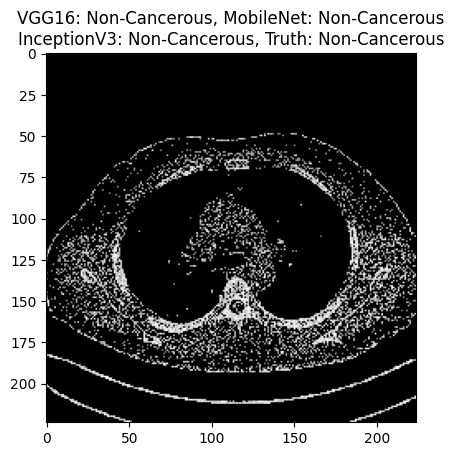

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


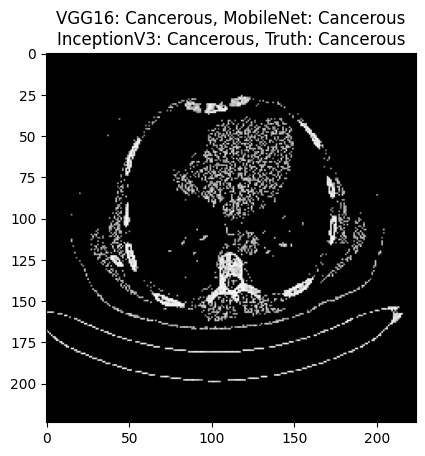

In [ ]:
batch = next(test_dataset)

def predAll(batch, i):
  label_dict = {0: 'Cancerous', 1: 'Non-Cancerous'}
  vgg16Pred = 0 if VGG16.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1
  mobilenetPred = 0 if MOBILENET.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1
  inceptionv3Pred = 0 if InceptionV3.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1

  return f'VGG16: {label_dict[vgg16Pred]}, MobileNet: {label_dict[mobilenetPred]}\nInceptionV3: {label_dict[inceptionv3Pred]}, Truth: {label_dict[int(batch[1][i])]}'

print('Predicted vs True labels')
# Ảnh 1
plt.figure()
plt.imshow(batch[0][0])
label = predAll(batch, 0)
plt.title(label)
plt.show()

# Ảnh 2
plt.figure()
plt.imshow(batch[0][5])
label = predAll(batch, 1)
plt.title(label)
plt.show()

plt.show()


In [81]:
eval = [VGG16_scores, MOBILENET_scores, InceptionV3_scores]
eval

[[0.1711723506450653,
  0.9547511339187622,
  0.9622641801834106,
  0.9444444179534912,
  0.9846771359443665],
 [0.09497085958719254,
  0.9683257937431335,
  0.954954981803894,
  0.9814814925193787,
  0.9929121732711792],
 [0.13628454506397247,
  0.959276020526886,
  0.9714285731315613,
  0.9444444179534912,
  0.9865617752075195]]

<div style='font-size:100%;'>
    <a id='analysis'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center> Comparative analysis of the models </center>
    </h1>
</div></center>

In [83]:
indices = ['VGG16', 'MobileNet', 'InceptionV3']
scores = pd.DataFrame({'Accuracy': [item[1] for item in eval],'Precision': [item[2] for item in eval], 'Recall': [item[3] for item in eval], 'AUC': [item[4] for item in eval]}, index=indices)
scores

,Accuracy,Precision,Recall,AUC
VGG16,0.954751,0.962264,0.944444,0.984677
MobileNet,0.968326,0.954955,0.981481,0.992912
InceptionV3,0.959276,0.971429,0.944444,0.986562


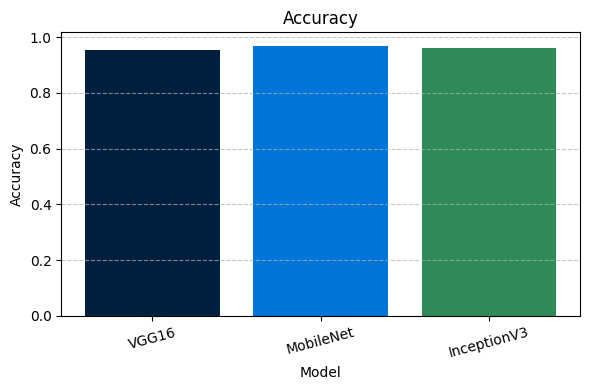

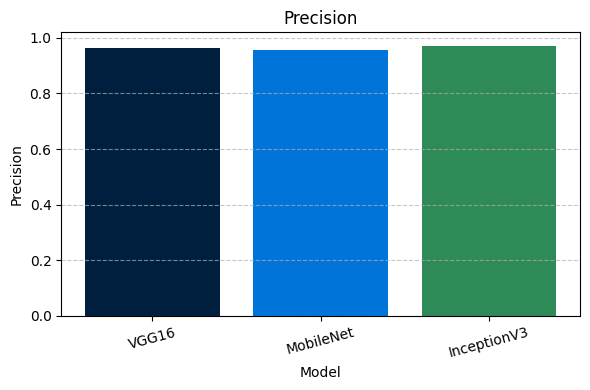

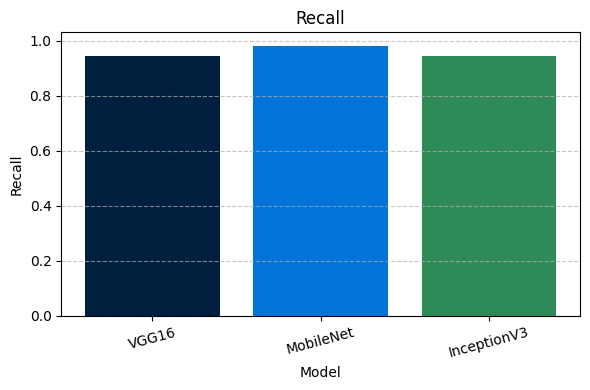

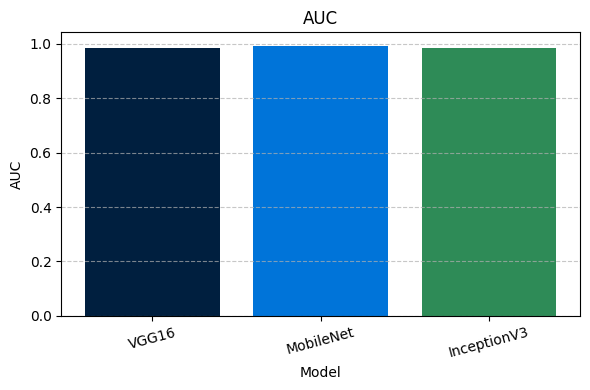

In [112]:
# Define colors for each model
model_colors = {
    model: color for model, color in zip(scores.index, ['#001f3f', '#0074D9', '#2E8B57', '#8B0000', '#A9A9A9'])
}

# Plot each metric separately
for column in scores.columns:
    plt.figure(figsize=(6, 4))
    bars = plt.bar(scores.index, scores[column], color=[model_colors[model] for model in scores.index])
    plt.xlabel('Model')
    plt.ylabel(column)
    plt.title(f'{column}')
    plt.xticks(rotation=15)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [74]:
eval = np.array(eval)
np.savetxt('eval.txt', eval)

<div style='font-size:100%;'>
    <a id='references'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center> References </center>
    </h1>
</div></center>


1. [1] Tekade, Ruchita, and K. Rajeswari. "Lung cancer detection and classification using deep learning." 2018 Fourth International Conference on Computing Communication Control and Automation (ICCUBEA). IEEE, 2018.
2. [2] Bhatia, Siddharth, Yash Sinha, and Lavika Goel. "Lung cancer detection: a deep learning approach." Soft Computing for Problem Solving. Springer, Singapore, 2019. 699-705.
3. [3] Radhika, P. R., Rakhi AS Nair, and G. Veena. "A comparative study of lung cancer detection using machine learning algorithms." 2019 IEEE International Conference on Electrical, Computer and Communication Technologies (ICECCT). IEEE, 2019.
4. [4] Shakeel, P. Mohamed, Mohd Aboobaider Burhanuddin, and Mohamad Ishak Desa. "Lung cancer detection from CT image using improved profuse clustering and deep learning instantaneously trained neural networks." Measurement 145 (2019): 702-712.
5. [5] Asuntha, A., and Andy Srinivasan. "Deep learning for lung Cancer detection and classification." Multimedia Tools and Applications 79.11 (2020): 7731-7762.
6. [6] Joshua, Eali Stephen Neal, Midhun Chakkravarthy, and Debnath Bhattacharyya. "An Extensive Review on Lung Cancer Detection Using Machine Learning Techniques: A Systematic Study." Rev. d'Intelligence Artif. 34.3 (2020): 351-359.
7. [7] Alsinglawi, Belal, et al. "An explainable machine learning framework for lung cancer hospital length of stay prediction." Scientific reports 12.1 (2022): 1-10.
8. [8] Yan, Sha, et al. "Computed Tomography Images under Deep Learning Algorithm in the Diagnosis of Perioperative Rehabilitation Nursing for Patients with Lung Cancer." Scientific Programming 2022 (2022).
9. [9] Elnakib, Ahmed, Hanan M. Amer, and Fatma EZ Abou-Chadi. "Early lung cancer detection using deep learning optimization." (2020): 82-94.
10. [10] Shimazaki, Akitoshi, et al. "Deep learning-based algorithm for lung cancer detection on chest radiographs using the segmentation method." Scientific reports 12.1 (2022): 1-10.
11. [11] Hosseini, Hesamoddin, Reza Monsefi, and Shabnam Shadroo. "Deep Learning Applications for Lung Cancer Diagnosis: A systematic review." arXiv preprint arXiv:2201.00227 (2022).
12. [12] Li, Wenzhe, et al. "Machine Learning-Assisted Dual-Marker Detection in Serum Small Extracellular Vesicles for the Diagnosis and Prognosis Prediction of Non-Small Cell Lung Cancer." Nanomaterials 12.5 (2022): 809.